# In this example we will show how to generate masks, including lans/sea masks

Notebook can be accessed [here](notebook.ipynb)

## Preparing the notebook

In [1]:
import requests
r = requests.get("https://uvcdat.llnl.gov/cdat/sample_data/clt.nc",stream=True)
with open("clt.nc","wb") as f:
    for chunk in r.iter_content(chunk_size=1024):
        if chunk:  # filter local_filename keep-alive new chunks
            f.write(chunk)

# and load data
import cdms2
f = cdms2.open("clt.nc")
clt = f("clt", time=slice(0,1), squeeze=1) # Get first month
u = f("u", level=slice(0,1), squeeze=1)
v = f("v", level=slice(0,1), squeeze=1)
clt = clt.regrid(u.getGrid(), regridTool="regrid2") # Put data on same grid

# computes wind speed
import MV2
speed = MV2.sqrt(u**2+v**2)
print "Max speed:", speed.max()
print "Mean speed:",speed.mean()
print "Min speed:",speed.min()

# Prepare graphics
import vcs
x=vcs.init()

Max speed: 68.9132
Mean speed: 16.2591233086
Min speed: 0.0611087


## Value based  masks

/Users/doutriaux1/anaconda2/envs/2.12-nox/lib/python2.7/site-packages/vcs/VTKPlots.py:998: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  data[:] = numpy.ma.masked_invalid(data, numpy.nan)
/Users/doutriaux1/anaconda2/envs/2.12-nox/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/doutriaux1/anaconda2/envs/2.12-nox/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


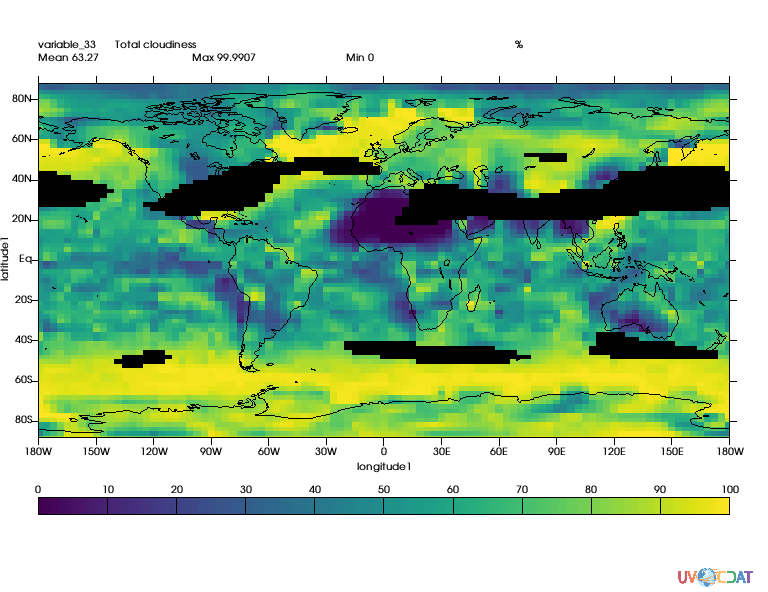

In [2]:
# Let's mask out area where wind speed is greater than twice mean
mask = MV2.greater(speed,speed.mean()*2.)

# Let's apply this mask
clt_masked = MV2.masked_where(mask,clt)
x.plot(clt_masked)

## Land-sea Masks

### Generating a landsea mask on any grid

Conveniently CDAT can generate masks for you (for regular grids only).

The observed data set used here as the basis for creating realistic model land/sea masks was obtained from the U.S. Navy on a 1/6 degree longitude-latitude grid.

more on the technique used can be read [here](https://www-pcmdi.llnl.gov/publications/pdf/58.pdf)

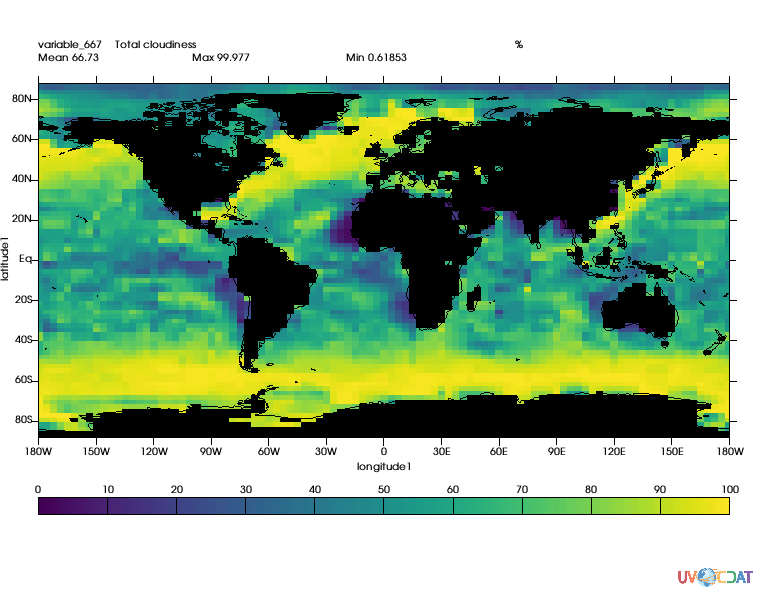

In [3]:
import cdutil
mask = cdutil.generateLandSeaMask(clt)
mask2 = MV2.where(mask._mask,1.,mask) # Not needed for cdutil versions >= 2.12.2017.9.25
mask2.setAxisList(mask.getAxisList()) # Not needed for cdutil versions >= 2.12.2017.9.25
clt_masked = MV2.masked_where(mask2,clt)
x.clear()
x.plot(clt_masked)

### Surface type by region masks

CDAT also provide capabilities to mask regions. Original regions and their numbers come from [EzGet](http://github.com/uv-cdat/ezget)

The function requires both a land/sea mask and a file reporting "regions", default "region" mask is as follow:
<img src="colorgeog.png">

Regions tables is:
<img src="table.png">


In [4]:
regions, guess = cdutil.generateSurfaceTypeByRegionMask(mask2*100., verbose=False)

Done : |                                       | 0.00Done : ##                                      | 4.76Done : ####                                    | 9.Done : ######                                  | 14.29Done : ########                                | 19.Done : ##########                              | 23.Done : ############                            | 28.Done : ##############                          | 33.33Done : ################                        | 38.10Done : ##################                      | 42.86Done : ####################                    | 47.62Done : #####################                   | 52.Done : #######################                 | 57.Done : #########################               | 61.Done : ###########################             | 66.Done : #############################           | 71.Done : ###############################         | 76.Done : #################################       | 80.95Done : ###################################     | 8

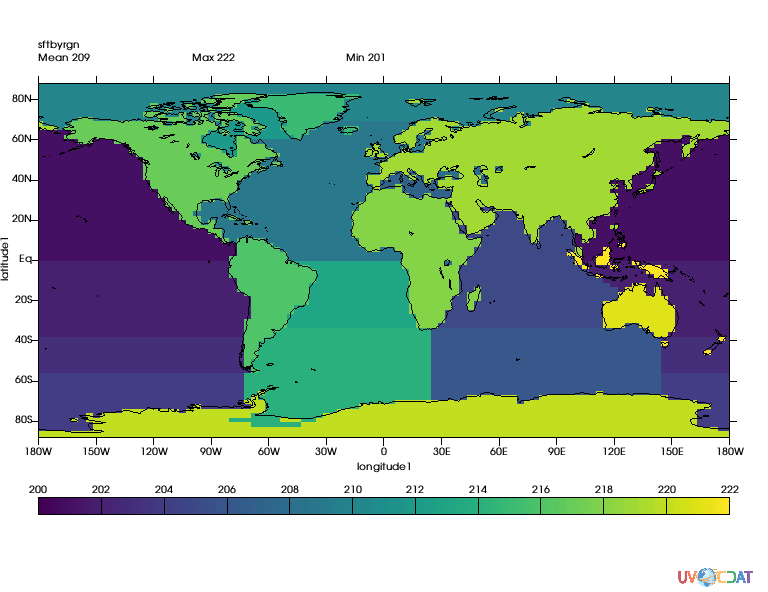

In [5]:
# let's take a look
x.clear()
x.plot(regions)

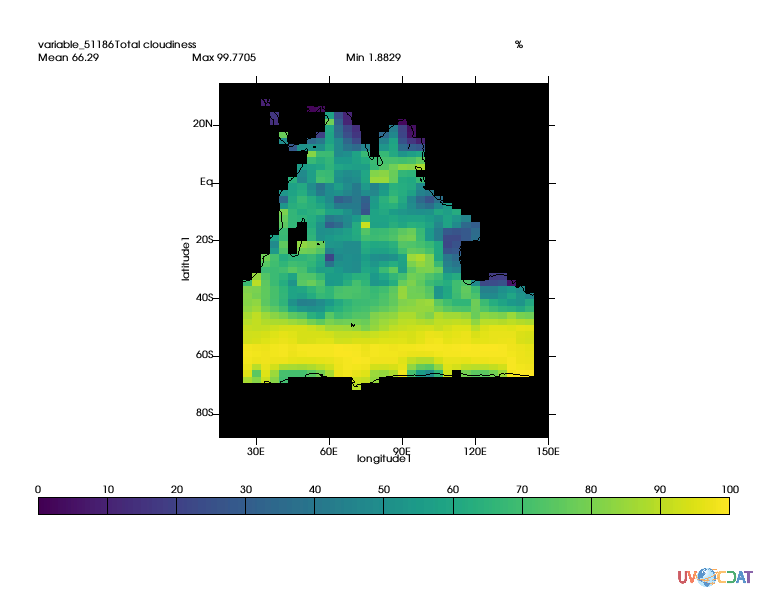

In [6]:
# Now let's extract the indian ocean which according to table are area 205 and 206
ind1 = MV2.equal(regions,205)
ind2 = MV2.equal(regions,206)
indian_ocean = MV2.logical_or(ind1,ind2)

clt_indian_ocean = MV2.masked_where(MV2.logical_not(indian_ocean),clt)
x.clear()
x.plot(clt_indian_ocean(longitude=(15,150),latitude=(-90,35)),ratio="autot")